# Import Packages

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time

# Exploratory Data Analysis

## Check total number of fruit types and fruit color

In [2]:
# Set root directory
root_dir = "data/"
images = []
fruit_types = []
colors = []
        
# Assume subdirectories are fruit types
for fruit_color_type in os.listdir(root_dir):
    fruit_path = os.path.join(root_dir, fruit_color_type)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            # print(img_name)
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(fruit_path, img_name)
                # print(img_path)
                # Add image path
                images.append(img_path)
                # Extract fruit type
                fruit_color_type_splitted = fruit_color_type.split()
                fruit_type = fruit_color_type_splitted[0]
                # Extract fruit color
                fruit_color = fruit_color_type_splitted[1]
                # Append fruit color and type to list
                fruit_types.append(fruit_type)
                colors.append(fruit_color)

print(f"Total number of fruit types: {len(set(fruit_types))}")
print(f"Total number of fruit colors: {len(set(colors))}")

Total number of fruit types: 18
Total number of fruit colors: 8


In [3]:
list(set(fruit_types)), list(set(colors))

(['Mandarine',
  'Corn',
  'Apple',
  'Lemon',
  'Cherry',
  'Orange',
  'Pineapple',
  'Strawberry',
  'Potato',
  'Grape',
  'Avocado',
  'Pepper',
  'Banana',
  'Onion',
  'Mango',
  'Tomato',
  'Pear',
  'Peach'],
 ['Red', 'Yellow', 'Orange', 'Black', 'Brown', 'Blue', 'Green', 'White'])

## Check total number of images in datasets

In [4]:
print(f"Total number of images in datasets: {len(images)}")

Total number of images in datasets: 45219


## Check height and width distribution, file size distribution, and color mode distribution.

Analyzing images...


100%|██████████| 45219/45219 [00:12<00:00, 3645.64it/s]


Calculating average colors...


100%|██████████| 45219/45219 [00:05<00:00, 8298.95it/s]



Basic Statistics:
         width   height  aspect_ratio       size_kb         avg_r  \
count  45219.0  45219.0       45219.0  45219.000000  45219.000000   
mean     100.0    100.0           1.0      4.400500    164.046220   
std        0.0      0.0           0.0      0.735362     39.223716   
min      100.0    100.0           1.0      2.275391     57.000000   
25%      100.0    100.0           1.0      3.965820    143.000000   
50%      100.0    100.0           1.0      4.357422    168.000000   
75%      100.0    100.0           1.0      4.817383    191.000000   
max      100.0    100.0           1.0      7.250000    241.000000   

              avg_g         avg_b  
count  45219.000000  45219.000000  
mean     128.899533    106.586899  
std       42.541468     35.799129  
min       46.000000     44.000000  
25%       97.000000     77.000000  
50%      126.000000    103.000000  
75%      159.000000    127.000000  
max      237.000000    219.000000  


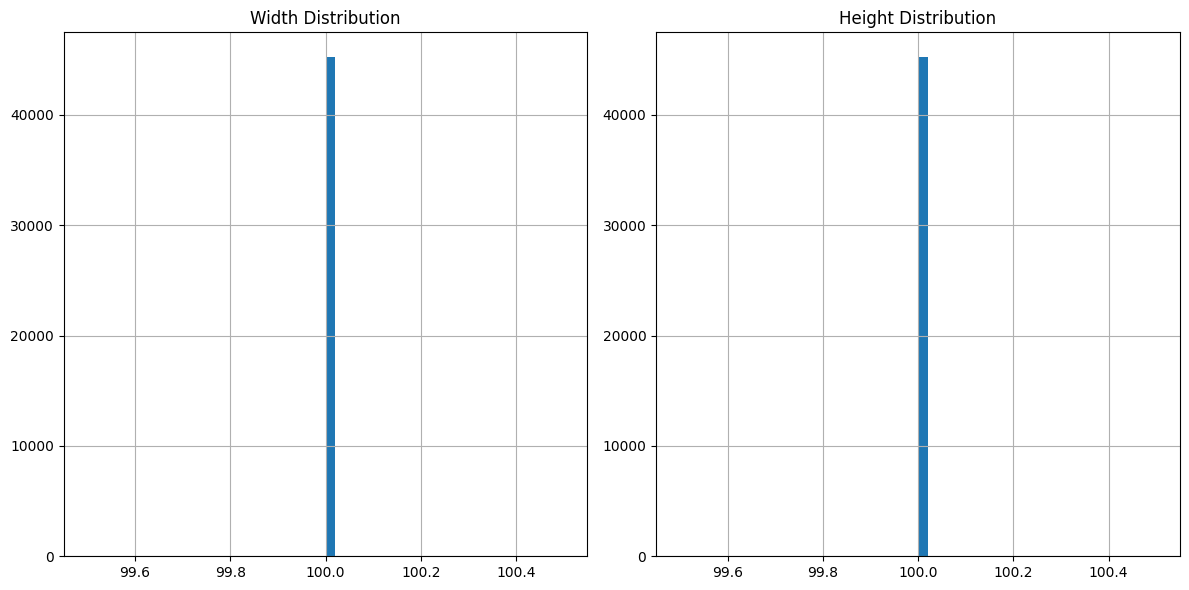

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms
import torch
import torch.nn.functional as F
from tqdm import tqdm

def analyze_image(img_path):
    try:
        with Image.open(img_path) as img:
            return {
                'filename': os.path.basename(img_path),
                'width': img.width,
                'height': img.height,
                'aspect_ratio': img.width / img.height,
                'mode': img.mode,
                'format': img.format,
                'size_kb': os.path.getsize(img_path) / 1024
            }
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

def get_average_color(img_path):
    with Image.open(img_path) as img:
        img = img.convert('RGB')
        img = img.resize((1, 1))
        return img.getpixel((0, 0))

def analyze_dataset(root_dir):
    image_data = []
    fruit_colors = []
    image_paths = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
                fruit_color = '_'.join(file.split('_')[:2])
                fruit_colors.append(fruit_color)

    print("Analyzing images...")
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(analyze_image, image_paths), total=len(image_paths)))

    image_data = [r for r in results if r is not None]
    
    print("Calculating average colors...")
    avg_colors = list(tqdm(map(get_average_color, image_paths), total=len(image_paths)))
    
    df = pd.DataFrame(image_data)
    df['avg_r'], df['avg_g'], df['avg_b'] = zip(*avg_colors)
    
    return df, fruit_colors

# Replace with your dataset path
root_dir1 = 'data/"Avocado Green"/9_100.jpg'

df, fruit_colors = analyze_dataset(root_dir)

# 1. Basic Statistics
print("\nBasic Statistics:")
print(df.describe())

# 2. Image Dimensions Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['width'].hist(bins=50)
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
df['height'].hist(bins=50)
plt.title('Height Distribution')
plt.tight_layout()
plt.show()

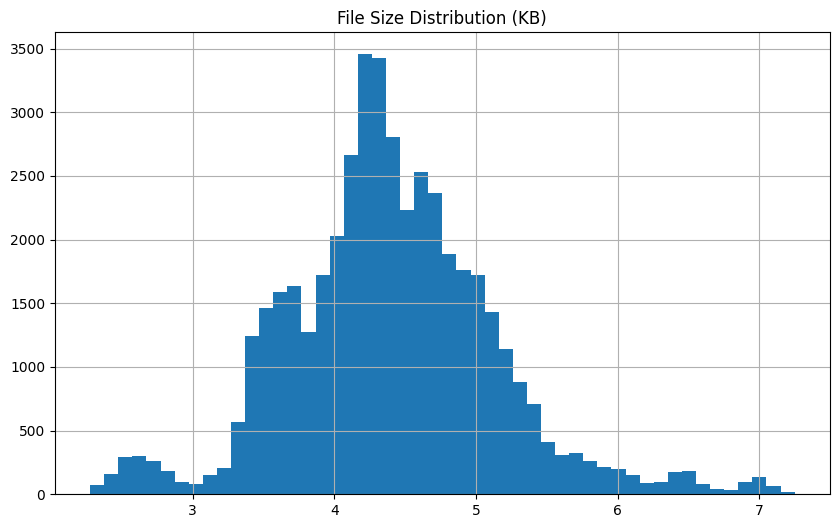

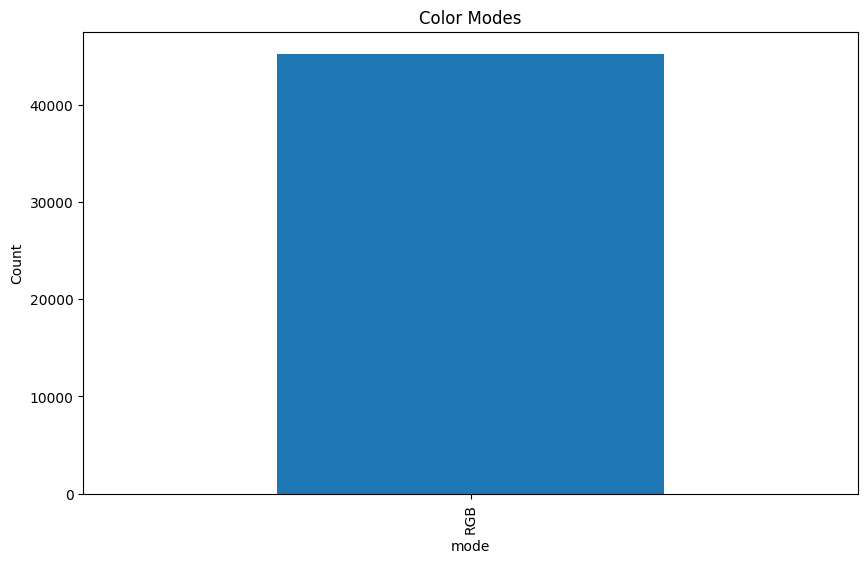

In [6]:
# 3. File Size Distribution
plt.figure(figsize=(10, 6))
df['size_kb'].hist(bins=50)
plt.title('File Size Distribution (KB)')
plt.savefig('file_size_distribution.png')
plt.show()


# 4. Color Modes
mode_counts = df['mode'].value_counts()
plt.figure(figsize=(10, 6))
mode_counts.plot(kind='bar')
plt.title('Color Modes')
plt.ylabel('Count')
plt.show()

# Convert Image Data to torch dataset format

In [7]:
def calculate_mean_std(dataset):
    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
    )
    
    mean = 0.
    std = 0.
    for images, _, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    return mean, std

In [8]:
# Define Fruit Dataset Class
class FruitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.fruit_types = []
        self.colors = []
        
        # Assume subdirectories are fruit types
        for fruit_color_type in os.listdir(root_dir):
            fruit_path = os.path.join(root_dir, fruit_color_type)
            if os.path.isdir(fruit_path):
                for img_name in os.listdir(fruit_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(fruit_path, img_name)
                        # Add image path
                        self.images.append(img_path)
                        # Extract fruit type
                        fruit_color_type_splitted = fruit_color_type.split()
                        fruit_type = fruit_color_type_splitted[0]
                        # Extract fruit color
                        fruit_color = fruit_color_type_splitted[1]
                        # Append fruit color and type to list
                        self.fruit_types.append(fruit_type)
                        self.colors.append(fruit_color)

        # Sort fruit types and color list
        unique_fruit_types = list(set(self.fruit_types))
        unique_fruit_colors = list(set(self.colors))
        unique_fruit_types.sort()
        unique_fruit_colors.sort()
                
        # Create dictionaries to map labels to indices
        self.fruit_type_to_idx = {fruit: idx for idx, fruit in enumerate(unique_fruit_types)}
        self.color_to_idx = {color: idx for idx, color in enumerate(unique_fruit_colors)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        fruit_type = self.fruit_types[idx]
        color = self.colors[idx]

        if self.transform:
            image = self.transform(image)

        return (image, 
                self.fruit_type_to_idx[fruit_type], 
                self.color_to_idx[color])

In [9]:
# # INITIAL TRANSFORMATION
# # Load images, fruit_type, and fruit_color labels as dataset and transform the image
# initial_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# # Convert to FruitDataset 
# initial_dataset = FruitDataset(root_dir="data/", transform=initial_transform)

# # Calculate mean and std of dataset
# mean, std = calculate_mean_std(initial_dataset)

# print(f"Dataset mean: {mean}")
# print(f"Dataset std: {std}")

In [10]:
# Load images, fruit_type, and fruit_color labels as dataset and transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Convert to FruitDataset 
dataset = FruitDataset(root_dir="data/", transform=transform)

# Create dataloader (batch size = 32)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

from torch.utils.data import random_split

# Data splitting
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
dataset.fruit_type_to_idx, dataset.color_to_idx

({'Apple': 0,
  'Avocado': 1,
  'Banana': 2,
  'Cherry': 3,
  'Corn': 4,
  'Grape': 5,
  'Lemon': 6,
  'Mandarine': 7,
  'Mango': 8,
  'Onion': 9,
  'Orange': 10,
  'Peach': 11,
  'Pear': 12,
  'Pepper': 13,
  'Pineapple': 14,
  'Potato': 15,
  'Strawberry': 16,
  'Tomato': 17},
 {'Black': 0,
  'Blue': 1,
  'Brown': 2,
  'Green': 3,
  'Orange': 4,
  'Red': 5,
  'White': 6,
  'Yellow': 7})

In [12]:
len(train_dataset), len(val_dataset)

(36175, 9044)

# Model

In [13]:
import torchvision.models as models
import torch.nn as nn

In [14]:
# class FruitClassifier(nn.Module):
#     def __init__(self, num_fruit_types, num_colors, num_freezed, resnet_version="resnet50"):
#         super(FruitClassifier, self).__init__()
#         # Load pretrained resnet50 model
#         if resnet_version == "resnet50":
#             self.resnet = models.resnet50(pretrained=True)
#         elif resnet_version == 'resnet101':
#             self.resnet = models.resnet101(pretrained=True)

#         # Get the total number of layers
#         total_layers = len(list(self.resnet.named_parameters()))

#         # Calculate the number of layers to freeze (3/4 of total)
#         layers_to_freeze = int(total_layers * num_freezed)

#         # Freeze the first 3/4 of the layers
#         for i, (name, param) in enumerate(self.resnet.named_parameters()):
#             if i < layers_to_freeze:
#                 param.requires_grad = False
#             else:
#                 param.requires_grad = True
        
#         # Replace the last fully connected layer
#         num_ftrs = self.resnet.fc.in_features
#         self.resnet.fc = nn.Identity()
        
#         # Add new layers for fruit type and color classification
#         self.fruit_type_fc = nn.Linear(num_ftrs, num_fruit_types)
#         self.color_fc = nn.Linear(num_ftrs, num_colors)

#     def forward(self, x):
#         features = self.resnet(x)
#         fruit_type = self.fruit_type_fc(features)
#         fruit_type = F.softmax(fruit_type, dim=1)

#         color = self.color_fc(features)
#         color = F.softmax(color, dim=1)

#         return fruit_type, color

In [15]:
class FruitClassifier(nn.Module):
    def __init__(self, num_fruit_types, num_colors, resnet_version="resnet50"):
        super(FruitClassifier, self).__init__()
        # Load pretrained resnet50 model
        if resnet_version == "resnet50":
            self.resnet = models.resnet50(pretrained=True)
        elif resnet_version == 'resnet101':
            self.resnet = models.resnet101(pretrained=True)

        # Freeze the parameters of the pre-trained model
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        # Add new layers for fruit type and color classification
        self.fruit_type_fc = nn.Linear(num_ftrs, num_fruit_types)
        self.color_fc = nn.Linear(num_ftrs, num_colors)

    def forward(self, x):
        features = self.resnet(x)
        fruit_type = self.fruit_type_fc(features)
        fruit_type = F.softmax(fruit_type, dim=1)

        color = self.color_fc(features)
        color = F.softmax(color, dim=1)

        return fruit_type, color

In [16]:
# Load Pretrained Model
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_fruit_types = len(set(dataset.fruit_types))
num_fruit_colors = len(set(dataset.colors))

model = FruitClassifier(num_fruit_types=num_fruit_types, num_colors=num_fruit_colors, resnet_version="resnet50").to(device=device)

/root/anaconda3/envs/03_fruit_clf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/03_fruit_clf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Define loss criterion
criterion_type = nn.CrossEntropyLoss()
criterion_color = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
is_print = False
loss_history = {
                "train": 
                    {
                        "fruit_type_loss": [],
                        "fruit_color_loss": [],
                        "fruit_type_acc": [],
                        "fruit_color_acc": [],
                        "total_loss": []                        
                    },
                "val":
                    {
                        "fruit_type_loss": [],
                        "fruit_color_loss": [],
                        "fruit_type_acc": [],
                        "fruit_color_acc": [],  
                        "total_loss": []
                    }}

def train_model(epoch, model, train_data=train_dataloader):
    model.train()

    N = len(train_data.dataset)
    step = N // train_data.batch_size 

    fruit_type_loss = 0.0
    fruit_color_loss = 0.0
    avg_loss = 0.0

    acc_type = 0.0
    acc_color = 0.0

    for i, (images, fruit_types, colors) in enumerate(train_data):
        if torch.cuda.is_available():
            images, fruit_types, colors = images.cuda(), fruit_types.cuda(), colors.cuda()
        else:
            images, fruit_types, colors = images.cpu(), fruit_types.cpu(), colors.cpu()

        # Inference
        outputs_type, outputs_color = model(images)


        # Calculate loss
        loss_type = criterion_type(outputs_type, fruit_types)
        loss_color = criterion_color(outputs_color, colors) 
        loss = loss_type + loss_color

        # Optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # statistics of model training
        avg_loss = (avg_loss * i + loss) / (i + 1)
        accuracy_fruit = accuracy_type_color(outputs_type, outputs_color, fruit_types, colors)
        # Accuracy
        acc_type += accuracy_fruit[0]
        acc_color += accuracy_fruit[1]
        # Loss
        fruit_type_loss += loss_type
        fruit_color_loss += loss_color

        # Add loss and accuracy to history 
        len_batch_size = outputs_type.shape[0]
        loss_history["train"]["fruit_type_loss"].append(float(loss_type))
        loss_history["train"]["fruit_color_loss"].append(float(loss_color))
        loss_history["train"]["fruit_type_acc"].append(float(accuracy_fruit[0]) / len_batch_size)
        loss_history["train"]["fruit_color_acc"].append(float(accuracy_fruit[1]) / len_batch_size)
        loss_history["train"]["total_loss"].append(float(loss))
        

        # report statistics
        # sys.stdout.flush()
        # sys.stdout.write("\r  Train_Step: %d/%d | runing_loss: %.4f" % (i + 1, step, avg_loss))
        if is_print:
            print("\r  Train_Step: %d/%d | runing_loss: %.4f" % (i + 1, step, avg_loss))


    return torch.Tensor([acc_type, acc_color, fruit_type_loss, fruit_color_loss]) / N

def valid_model(epoch, model, valid_data=val_dataloader):
    model.eval()

    N = len(valid_data.dataset)
    step = N // valid_data.batch_size 

    fruit_type_loss = 0.0
    fruit_color_loss = 0.0

    acc_type = 0.0
    acc_color = 0.0

    for i, (images, fruit_types, colors) in enumerate(valid_data):
        if torch.cuda.is_available():
            images, fruit_types, colors = images.cuda(), fruit_types.cuda(), colors.cuda()
        else:
            images, fruit_types, colors = images.cpu(), fruit_types.cpu(), colors.cpu()

        # Inference
        outputs_type, outputs_color = model(images)

        # Calculate loss
        loss_type = criterion_type(outputs_type, fruit_types)
        loss_color = criterion_color(outputs_color, colors) 
        loss = loss_type + loss_color

        # statistics of model validation
        accuracy_fruit = accuracy_type_color(outputs_type, outputs_color, fruit_types, colors)
        # Accuracy
        acc_type += accuracy_fruit[0]
        acc_color += accuracy_fruit[1]
        # Loss
        fruit_type_loss += loss_type
        fruit_color_loss += loss_color

        # Add loss and accuracy to history 
        len_batch_size = outputs_type.shape[0]
        loss_history["val"]["fruit_type_loss"].append(float(loss_type))
        loss_history["val"]["fruit_color_loss"].append(float(loss_color))
        loss_history["val"]["fruit_type_acc"].append(float(accuracy_fruit[0]) / len_batch_size)
        loss_history["val"]["fruit_color_acc"].append(float(accuracy_fruit[1]) / len_batch_size)
        loss_history["val"]["total_loss"].append(float(loss))

        # report statistics
        # sys.stdout.flush()
        # sys.stdout.write("\r  Train_Step: %d/%d | runing_loss: %.4f" % (i + 1, step, avg_loss))
        if is_print:
            print("\r  Valid_Step: %d/%d" % (i + 1, step))


    return torch.Tensor([acc_type, acc_color, fruit_type_loss, fruit_color_loss]) / N


def accuracy_type_color(outputs_type, outputs_color, fruit_types, colors):
    # Fruit type
    pred_fruit_type = torch.argmax(outputs_type[:, :-1], dim=1)
    y = fruit_types
    accuracy_type = torch.sum(pred_fruit_type == y)

    # Fruit color
    num_colors = outputs_color.shape[1]
    pred_fruit_color = torch.argmax(outputs_color[:, :-1], dim=1)
    y = colors
    accuracy_color = torch.sum(pred_fruit_color == y)

    return accuracy_type, accuracy_color

In [18]:
# Training loop
num_epochs = 20
weight_path = "weights/trial16_resnet50_normalized.pth"

for epoch in range(num_epochs):
    print('Epoch %2d/%2d' % (epoch + 1, num_epochs))
    print('-' * 15)
    t0 = time.time()

    train_metrics = train_model(epoch, model, train_dataloader)
    val_metrics = valid_model(epoch, model, val_dataloader)

    time_elapsed = time.time() - t0
    print('  Training complete in: %.0fm %.0fs' % (time_elapsed // 60, time_elapsed % 60))
    print('| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |')
    print('| %.3f | %.3f | %.3f | %.3f   \n' % (val_metrics[0], val_metrics[1], train_metrics[0], train_metrics[1]))

# Save fine-tuned model
torch.save(model.state_dict(), weight_path)

Epoch  1/20
---------------
  Training complete in: 1m 41s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.786 | 0.610 | 0.685 | 0.453   

Epoch  2/20
---------------
  Training complete in: 1m 42s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.838 | 0.612 | 0.809 | 0.618   

Epoch  3/20
---------------
  Training complete in: 1m 42s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.838 | 0.612 | 0.832 | 0.619   

Epoch  4/20
---------------
  Training complete in: 1m 40s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.838 | 0.701 | 0.833 | 0.694   

Epoch  5/20
---------------
  Training complete in: 1m 41s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.838 | 0.701 | 0.833 | 0.710   

Epoch  6/20
---------------
  Training complete in: 1m 43s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.838 | 0.701 | 0.833 | 0.711   

Epoc

In [19]:
# Training loop
num_epochs = 20
weight_path = "weights/trial16_resnet50_normalized.pth"

for epoch in range(num_epochs):
    print('Epoch %2d/%2d' % (epoch + 1, num_epochs))
    print('-' * 15)
    t0 = time.time()

    train_metrics = train_model(epoch, model, train_dataloader)
    val_metrics = valid_model(epoch, model, val_dataloader)

    time_elapsed = time.time() - t0
    print('  Training complete in: %.0fm %.0fs' % (time_elapsed // 60, time_elapsed % 60))
    print('| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |')
    print('| %.3f | %.3f | %.3f | %.3f   \n' % (val_metrics[0], val_metrics[1], train_metrics[0], train_metrics[1]))

# Save fine-tuned model
torch.save(model.state_dict(), weight_path)

Epoch  1/20
---------------
  Training complete in: 1m 41s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.733 | 0.682 | 0.719 | 0.680   

Epoch  2/20
---------------
  Training complete in: 1m 42s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.774 | 0.682 | 0.744 | 0.681   

Epoch  3/20
---------------
  Training complete in: 1m 42s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.775 | 0.682 | 0.766 | 0.681   

Epoch  4/20
---------------
  Training complete in: 1m 41s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.773 | 0.711 | 0.766 | 0.701   

Epoch  5/20
---------------
  Training complete in: 1m 42s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.775 | 0.711 | 0.766 | 0.711   

Epoch  6/20
---------------
  Training complete in: 1m 44s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.775 | 0.711 | 0.767 | 0.711   

Epoc

KeyboardInterrupt: 

In [12]:
# Training loop
num_epochs = 7
weight_path = "weights/trial8_resnet50_normalized.pth"

for epoch in range(num_epochs):
    print('Epoch %2d/%2d' % (epoch + 1, num_epochs))
    print('-' * 15)
    t0 = time.time()

    train_metrics = train_model(epoch, model, train_dataloader)
    val_metrics = valid_model(epoch, model, val_dataloader)

    time_elapsed = time.time() - t0
    print('  Training complete in: %.0fm %.0fs' % (time_elapsed // 60, time_elapsed % 60))
    print('| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |')
    print('| %.3f | %.3f | %.3f | %.3f   \n' % (val_metrics[0], val_metrics[1], train_metrics[0], train_metrics[1]))

# Save fine-tuned model
torch.save(model.state_dict(), weight_path)

Epoch  1/ 7
---------------
  Training complete in: 1m 48s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.853 | 0.842 | 0.821 | 0.822   

Epoch  2/ 7
---------------
  Training complete in: 1m 49s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.854 | 0.844 | 0.845 | 0.839   

Epoch  3/ 7
---------------
  Training complete in: 1m 49s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.854 | 0.843 | 0.846 | 0.842   

Epoch  4/ 7
---------------
  Training complete in: 1m 49s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.854 | 0.844 | 0.846 | 0.844   

Epoch  5/ 7
---------------
  Training complete in: 1m 49s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.854 | 0.843 | 0.846 | 0.844   

Epoch  6/ 7
---------------
  Training complete in: 1m 51s
| val_acc_types | val_acc_color | train_acc_gender | train_acc_color |
| 0.854 | 0.842 | 0.846 | 0.842   

Epoc

In [19]:
import pandas as pd

train_loss = pd.DataFrame(loss_history["train"])
train_loss.to_csv("metrics/trial16_train_loss_resnet50.csv", index=False)

In [20]:
val_loss = pd.DataFrame(loss_history["val"])
val_loss.to_csv("metrics/trial16_val_loss_resnet50.csv", index=False)

# Evaluation

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
history_train_path = 'metrics/trial16_train_loss_resnet50.csv'
history_val_path = 'metrics/trial16_val_loss_resnet50.csv'

train_loss = pd.read_csv(history_train_path)
val_loss = pd.read_csv(history_val_path)

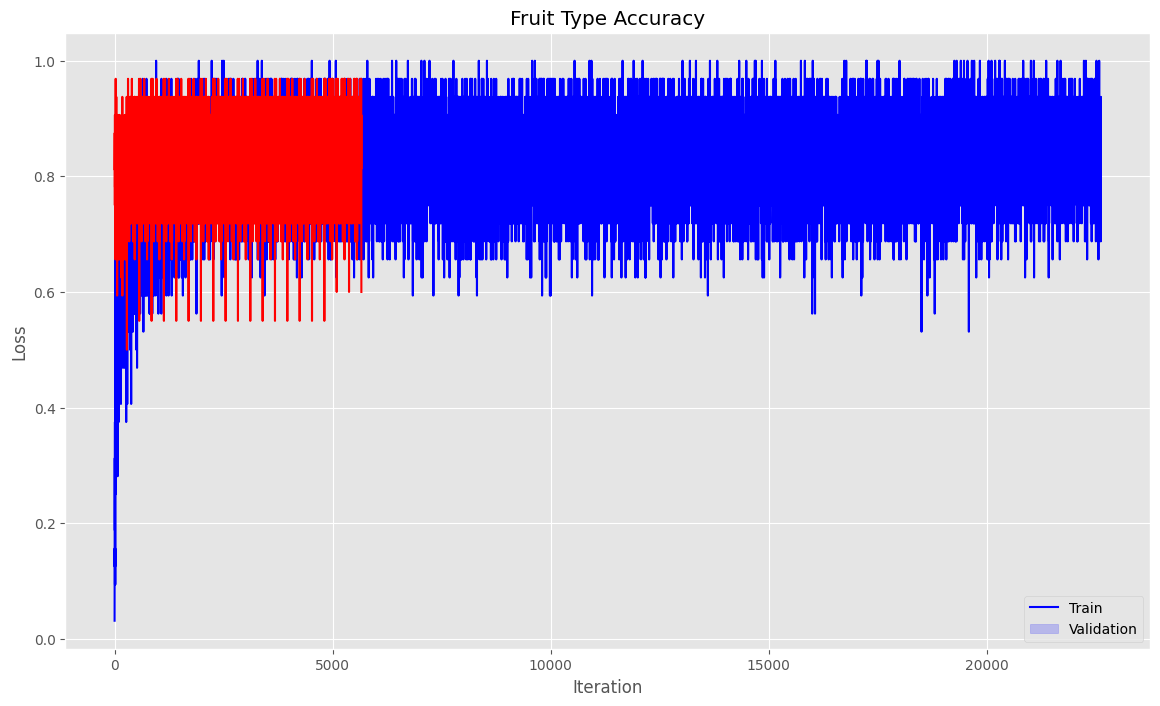

In [26]:
# Fruit Color Loss
plt.style.use('ggplot')

plt.figure(figsize=(14, 8))
sns.lineplot(x=train_loss.index, y=train_loss["fruit_type_acc"], color="blue")
sns.lineplot(x=val_loss.index, y=val_loss["fruit_type_acc"], color="red")

plt.legend(['Train', 'Validation'])

plt.title('Fruit Type Accuracy')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.show()

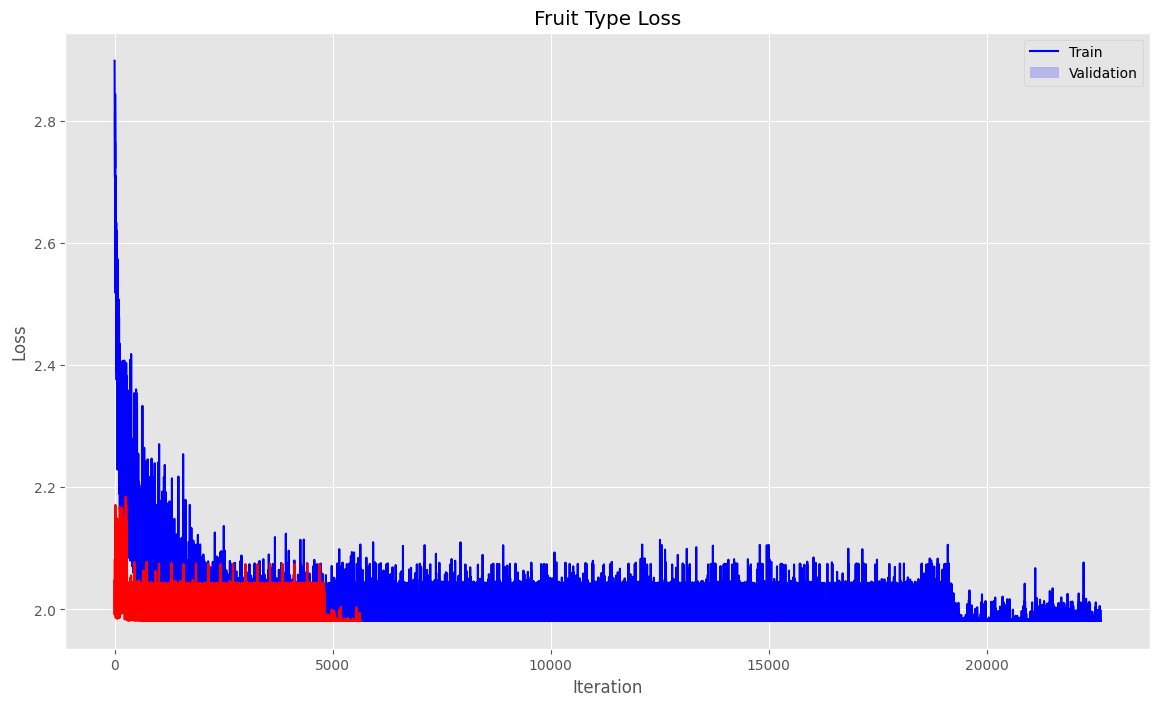

In [27]:
# Fruit Color Loss
plt.style.use('ggplot')

plt.figure(figsize=(14, 8))
sns.lineplot(x=train_loss.index, y=train_loss["fruit_type_loss"], color="blue")
sns.lineplot(x=val_loss.index, y=val_loss["fruit_type_loss"], color="red")

plt.legend(['Train', 'Validation'])

plt.title('Fruit Type Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.show()

In [22]:
train_loss.tail()

,fruit_type_loss,fruit_color_loss,fruit_type_acc,fruit_color_acc,total_loss
22615,1.981573,1.274024,0.87500,0.875000,3.255597
22616,1.982396,1.275865,0.81250,0.812500,3.258262
22617,1.981728,1.274185,0.84375,0.843750,3.255913
22618,1.981617,1.305217,0.93750,0.812500,3.286834
22619,1.981842,1.274016,0.80000,0.933333,3.255858


# Inference

In [23]:
from PIL import Image

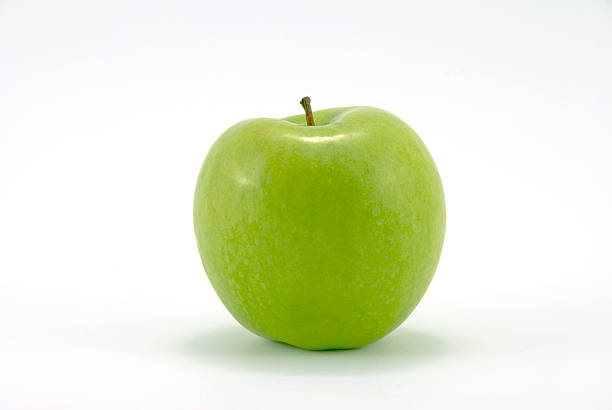

In [36]:
# sample_test_data = 
sample2 = "sample_data/image.png"
img = Image.open(sample2).convert('RGB')
img

In [15]:
model = FruitClassifier(num_fruit_types=num_fruit_types, num_colors=num_fruit_colors, resnet_version="resnet50").to(device=device)

/root/anaconda3/envs/03_fruit_clf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/03_fruit_clf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def inferece(image_path, model_weight):
    # Load data 
    img = Image.open(image_path).convert('RGB')

    # Transform image to tensor
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).float().to('cuda')

    # Load model
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.load_state_dict(torch.load(model_weight, map_location=device))
    model.to(device).eval()

    # Infence on image
    outputs_tensor = model(img_tensor)
    fruit_type_idx = int(torch.argmax(outputs_tensor[0][:, :-1]))
    fruit_color_idx = int(torch.argmax(outputs_tensor[1][:, :-1]))

    fruit_type_mapper = dataset.fruit_type_to_idx
    fruit_color_mapper = dataset.color_to_idx
    inverted_fruit_type_mapper = {v: k for k, v in fruit_type_mapper.items()}
    inverted_fruit_color_mapper = {v: k for k, v in fruit_color_mapper.items()}

    fruit_type = inverted_fruit_type_mapper[fruit_type_idx]
    fruit_color = inverted_fruit_color_mapper[fruit_color_idx]

    return f"{fruit_type} {fruit_color}"

In [23]:
inferece(image_path="sample_data/red_mango.png", model_weight="weights/trial6_resnet50_normalized.pth")

/tmp/ipykernel_929238/1772516346.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight, map_location=device))


'Mango Red'

# Others

In [71]:
root_dir = "data/"
# transform = transform
images = []
fruit_types = []
colors = []
        
# Assume subdirectories are fruit types
for fruit_color_type in os.listdir(root_dir):
    print(fruit_color_type)
    fruit_path = os.path.join(root_dir, fruit_color_type)
    if os.path.isdir(fruit_path):
        for img_name in os.listdir(fruit_path):
            # print(img_name)
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(fruit_path, img_name)
                print(img_path)
                # Add image path
                images.append(img_path)
                # Extract fruit type
                fruit_color_type_splitted = fruit_color_type.split()
                fruit_type = fruit_color_type_splitted[0]
                # Extract fruit color
                fruit_color = fruit_color_type_splitted[1]
                # Append fruit color and type to list
                fruit_types.append(fruit_type)
                colors.append(fruit_color)


Pear Green
Cherry Yellow
Corn Yellow
data/Corn Yellow/194_100.jpg
data/Corn Yellow/r_56_100.jpg
data/Corn Yellow/r2_121_100.jpg
data/Corn Yellow/r2_181_100.jpg
data/Corn Yellow/r2_116_100.jpg
data/Corn Yellow/r_60_100.jpg
data/Corn Yellow/r_76_100.jpg
data/Corn Yellow/r2_193_100.jpg
data/Corn Yellow/r2_93_100.jpg
data/Corn Yellow/104_100.jpg
data/Corn Yellow/r_114_100.jpg
data/Corn Yellow/136_100.jpg
data/Corn Yellow/r_24_100.jpg
data/Corn Yellow/r_148_100.jpg
data/Corn Yellow/27_100.jpg
data/Corn Yellow/r_62_100.jpg
data/Corn Yellow/r_17_100.jpg
data/Corn Yellow/196_100.jpg
data/Corn Yellow/r2_88_100.jpg
data/Corn Yellow/r_123_100.jpg
data/Corn Yellow/r_47_100.jpg
data/Corn Yellow/100_100.jpg
data/Corn Yellow/175_100.jpg
data/Corn Yellow/r_124_100.jpg
data/Corn Yellow/r2_190_100.jpg
data/Corn Yellow/r2_35_100.jpg
data/Corn Yellow/r2_104_100.jpg
data/Corn Yellow/151_100.jpg
data/Corn Yellow/r_180_100.jpg
data/Corn Yellow/81_100.jpg
data/Corn Yellow/r2_3_100.jpg
data/Corn Yellow/r_81_10

In [11]:
len(images), len(fruit_types), len(colors)

(8177, 8177, 8177)

In [12]:
images[2024], fruit_types[2024], colors[2024]

('data/Apple Red/156_100.jpg', 'Apple', 'Red')